In [20]:
import numpy as np
np.seterr(all="ignore")

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report

import renom as rm
from renom.optimizer import Adam
from renom.utility.initializer import Gaussian

# np.set_printoptions(threshold=np.inf)

In [21]:
# 'data_path' must point to the directory containing the data folder.
data_path = "../dataset"
mnist = fetch_mldata('MNIST original', data_home=data_path)

X = mnist.data
print(X, type(X), X.shape)
print(X[0])
y = mnist.target
print(y, type(y), y.shape)

# Binarize ("one-hot") the image data.
X = X.astype(np.float32)
print(X, type(X), X.dtype)
print(X[0])
y = y.astype(np.float32)
print(y, type(y))
# なんでfloatにしているのだろうか
X = np.array(X > 128, dtype=np.float32)
# print(X, type(X), X.dtype)
# なんで128より大きい要素の箇所のdtypeを再度floatにしているのだろうか

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

binarizer = LabelBinarizer()
label_train = binarizer.fit_transform(y_train)
label_test = binarizer.transform(y_test)

# Training data size.
N = len(x_train)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]] <class 'numpy.ndarray'> (70000, 784)
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0  51 159 253 159  50   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0  48 238 252 252 252 237   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0  54 227 253 252 239 233 252  57   6   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0  10

In [22]:
model_ae = rm.Sequential([
    # 隠れ層が100
        rm.Dense(100),
        rm.Relu(),
        rm.Dense(784),
    ])
optimizer = Adam()

epoch 00 train_loss:54.061375
epoch 02 train_loss:22.530745
epoch 04 train_loss:15.491749
epoch 06 train_loss:12.752005
epoch 08 train_loss:11.368758


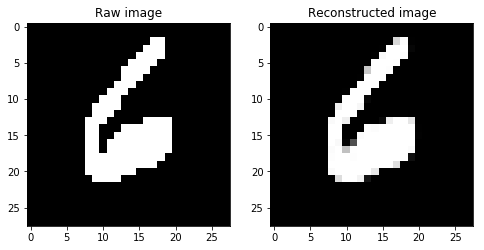

In [23]:
batch = 64
epoch = 10

# 学習アルゴリズム
# すぐに学習が終わるわけではないので、注意
for i in range(epoch):
    for j in range(N//batch):
        train_batch=x_train[j*batch:(j+1)*batch]
        with model_ae.train():
            z = model_ae(train_batch)
            # 入力データ自身が教師データとなる
            loss = rm.sigmoid_cross_entropy(z, train_batch)
        loss.grad().update(optimizer)
    if i%2 == 0:print("epoch %02d train_loss:%f"%(i, loss))

# Show raw img and reconstructed img.
test_img = x_test[0]
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(8, 6))
ax[0].set_title("Raw image")
ax[0].imshow(test_img.reshape(28, 28), cmap="gray")
ax[1].set_title("Reconstructed image")
ax[1].imshow(rm.sigmoid(model_ae(test_img)).reshape(28, 28), cmap="gray")
plt.show()

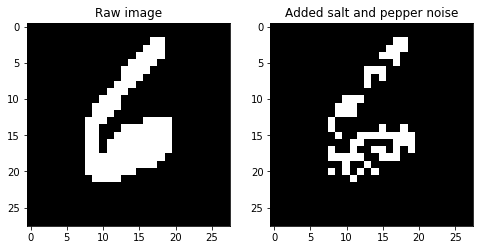

In [24]:
test_img = x_test[0].reshape(28, 28)
sp_noise = np.array(np.random.rand(*test_img.shape) > 0.5, dtype=np.bool)
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(8, 6))
ax[0].set_title("Raw image")
ax[0].imshow(test_img, cmap="gray")
ax[1].set_title("Added salt and pepper noise")
ax[1].imshow(test_img*sp_noise, cmap="gray")
plt.show()

In [25]:
model_denoise_ae = rm.Sequential([
        rm.Dense(100),
        rm.Relu(),
        rm.Dense(784),
    ])
optimizer = Adam()

epoch 00 train_loss:95.386124
epoch 02 train_loss:77.331291
epoch 04 train_loss:74.024048
epoch 06 train_loss:74.292931
epoch 08 train_loss:70.655663


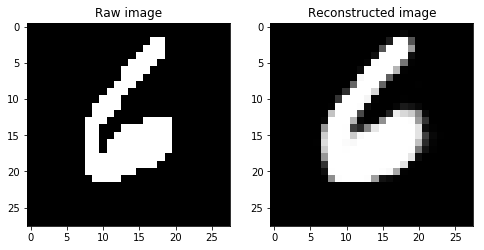

In [26]:
batch = 64
epoch = 10

for i in range(epoch):
    for j in range(N//batch):
        train_batch=x_train[j*batch:(j+1)*batch]
        with model_denoise_ae.train():
            sp_noise = np.array(np.random.rand(*train_batch.shape) > 0.5, dtype=np.bool)
            z = model_denoise_ae(train_batch*sp_noise)
            loss = rm.sigmoid_cross_entropy(z, train_batch)
        loss.grad().update(optimizer)
    if i%2 == 0:print("epoch %02d train_loss:%f"%(i, loss))

# Show raw img and reconstructed img.
test_img = x_test[0]
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(8, 6))
ax[0].set_title("Raw image")
ax[0].imshow(test_img.reshape(28, 28), cmap="gray")
ax[1].set_title("Reconstructed image")
ax[1].imshow(rm.sigmoid(model_denoise_ae(test_img)).reshape(28, 28), cmap="gray")
plt.show()

In [27]:
pretrained_ae = rm.Sequential([
        rm.Dense(100),
        rm.Relu(),
        rm.Dense(10),
    ])

pretrained_dae = rm.Sequential([
        rm.Dense(100),
        rm.Relu(),
        rm.Dense(10),
    ])

# Copy first weight parameters of first layer.
pretrained_ae[0].params = model_ae[0].params
pretrained_dae[0].params = model_denoise_ae[0].params

opt1 = Adam()
opt2 = Adam()

In [28]:
batch = 64
epoch = 100

train_loss1 = []
train_loss2 = []
validation_loss1 = []
validation_loss2 = []

for i in range(epoch):
    for j in range(N//batch):
        train_batch = x_train[j*batch:(j+1)*batch]
        response_batch = label_train[j*batch:(j+1)*batch].astype(np.float32)
        sp_noise = np.array(np.random.rand(*train_batch.shape) > 0.5)
        train_batch = train_batch*sp_noise

        with pretrained_ae.train():
            z = pretrained_ae(train_batch)
            loss1 = rm.softmax_cross_entropy(z, response_batch)

        with pretrained_dae.train():
            z = pretrained_dae(train_batch)
            loss2 = rm.softmax_cross_entropy(z, response_batch)

        loss1.grad().update(opt1)
        loss2.grad().update(opt2)

    validation1 = rm.softmax_cross_entropy(pretrained_ae(x_test), label_test)
    validation2 = rm.softmax_cross_entropy(pretrained_dae(x_test), label_test)

    train_loss1.append(loss1)
    train_loss2.append(loss2)
    validation_loss1.append(validation1)
    validation_loss2.append(validation2)

    strs = "epoch:%02d AE_loss:%f AE_validation:%f DAE_loss:%f DAE_validation:%f"
    if i%2 == 0:print(strs%(i, loss1, validation1, loss2, validation2))

epoch:00 AE_loss:0.456696 AE_validation:0.575411 DAE_loss:0.369653 DAE_validation:0.361761
epoch:02 AE_loss:0.370522 AE_validation:0.478866 DAE_loss:0.252624 DAE_validation:0.237025
epoch:04 AE_loss:0.394046 AE_validation:0.370761 DAE_loss:0.279858 DAE_validation:0.178876
epoch:06 AE_loss:0.283965 AE_validation:0.291737 DAE_loss:0.209363 DAE_validation:0.158158
epoch:08 AE_loss:0.252333 AE_validation:0.244000 DAE_loss:0.169399 DAE_validation:0.141019
epoch:10 AE_loss:0.204257 AE_validation:0.216831 DAE_loss:0.148049 DAE_validation:0.139820
epoch:12 AE_loss:0.144288 AE_validation:0.194994 DAE_loss:0.068125 DAE_validation:0.132708
epoch:14 AE_loss:0.262260 AE_validation:0.171441 DAE_loss:0.157283 DAE_validation:0.120577
epoch:16 AE_loss:0.116448 AE_validation:0.172870 DAE_loss:0.149002 DAE_validation:0.123730
epoch:18 AE_loss:0.210551 AE_validation:0.155178 DAE_loss:0.215236 DAE_validation:0.119687
epoch:20 AE_loss:0.107856 AE_validation:0.154420 DAE_loss:0.173428 DAE_validation:0.114297

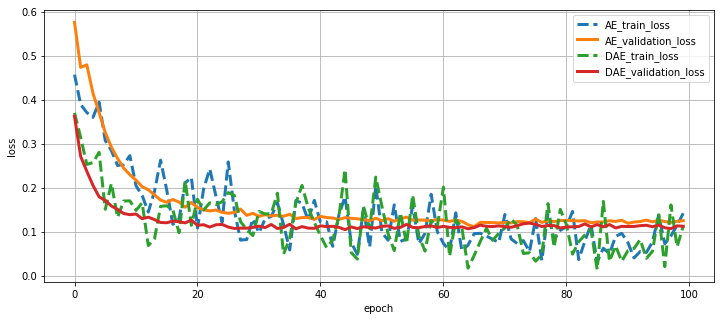

In [32]:
plt.figure(figsize=(12, 5))
plt.grid()
plt.plot(train_loss1, label="AE_train_loss", linestyle="--", linewidth=3)
plt.plot(validation_loss1, label="AE_validation_loss", linewidth=3)
plt.plot(train_loss2, label="DAE_train_loss", linestyle="--", linewidth=3)
plt.plot(validation_loss2, label="DAE_validation_loss", linewidth=3)
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend()
plt.show()

In [30]:
prediction1 = np.argmax(pretrained_ae(x_test).as_ndarray(), axis = 1)
prediction2 = np.argmax(pretrained_dae(x_test).as_ndarray(), axis = 1)

print("///////////// AE pretrained model //////////////")
print(classification_report(np.argmax(label_test, axis = 1), prediction1))

print("///////////// DAE pretrained model //////////////")
print(classification_report(np.argmax(label_test, axis = 1), prediction2))

///////////// AE pretrained model //////////////
             precision    recall  f1-score   support

          0       0.98      0.99      0.99       662
          1       0.97      0.99      0.98       793
          2       0.98      0.97      0.97       723
          3       0.98      0.97      0.98       670
          4       0.97      0.97      0.97       689
          5       0.98      0.96      0.97       667
          6       0.98      0.98      0.98       685
          7       0.98      0.98      0.98       725
          8       0.97      0.97      0.97       706
          9       0.96      0.97      0.97       680

avg / total       0.98      0.98      0.98      7000

///////////// DAE pretrained model //////////////
             precision    recall  f1-score   support

          0       0.99      0.99      0.99       662
          1       0.97      0.99      0.98       793
          2       0.98      0.97      0.98       723
          3       0.98      0.97      0.98       

https://elix-tech.github.io/ja/2016/07/17/autoencoder.html

In [31]:
from keras.layers import Input, Dense
from keras.models import Model
from keras.datasets import mnist
import numpy as np

encoding_dim = 32
input_img = Input(shape=(784,))
encoded = Dense(encoding_dim, activation='relu')(input_img)
decoded = Dense(784, activation='sigmoid')(encoded)
autoencoder = Model(input=input_img, output=decoded)

autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  # Remove the CWD from sys.path while we load stuff.
